In [1]:
# import files and define a function for reading our .json
import json
from networkx.readwrite import json_graph

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 

In [3]:
# import file with Arkansas data to a graph
file_path = '/spfda/datas/AR_county.json'
G = read_graph_from_json(file_path)

for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001'] # population of county
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20']  # longitude of county's center
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20']  # latitude of county's center

In [5]:
from geopy.distance import geodesic

# create a distance dictionary
dist = { (i,j) : 0 for i in G.nodes for j in G.nodes }
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'], G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'], G.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles

In [6]:
# we want a 1% population deviation
deviation = 0.01

import math
k = 4         # number of districts - 4 for AR
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 745353 and U = 760409 and k = 4


In [7]:
import gurobipy as gp
from gurobipy import GRB

# create gurobi model 
m = gp.Model()

# create x[i,j] variable which equals one when county i is assigned to (the district centered at) county j
x = m.addVars(G.nodes, G.nodes, vtype=GRB.BINARY)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27


In [8]:
# objective is to minimize the moment of inertia: sum (d^2 * p * x over all i and j)
m.setObjective(gp.quicksum(dist[i,j] * dist[i,j] * G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE)

In [9]:
# add constraints saying that each county i is assigned to one district
m.addConstrs(gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes)

# add constraint saying there should be k district centers
m.addConstr(gp.quicksum( x[j,j] for j in G.nodes ) == k)

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs(gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L * x[j,j] for j in G.nodes)
m.addConstrs(gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U * x[j,j] for j in G.nodes)

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs(x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes)

m.update()

In [10]:
# add contiguity constraints
import networkx as nx
DG = nx.DiGraph(G)

# add flow variables
#    f[i,j,v] = flow across arc (i,j) that is sent from souce/root v
f = m.addVars(DG.edges, G.nodes) 

# add constraints saying that if node i is assigned to node j, 
#   then node i must consume one unit of node j's flow
m.addConstrs(gp.quicksum( f[u,i,j] - f[i,u,j] for u in G.neighbors(i) ) == x[i,j] for i in G.nodes for j in G.nodes if i != j)

# add constraints saying that node i can receive flow of type j 
#   only if node i is assigned to node j
M = G.number_of_nodes() - 1
m.addConstrs(gp.quicksum( f[u,i,j] for u in G.neighbors(i) ) <= M * x[i,j] for i in G.nodes for j in G.nodes if i != j)

# add constraints saying that node j cannot receive flow of its own type
m.addConstrs(gp.quicksum( f[u,j,j] for u in G.neighbors(j) ) == 0 for j in G.nodes)

m.update()

In [11]:
# solve, making sure to set a 0.00% MIP gap tolerance
m.Params.MIPGap = 0.0

m.optimize()

Set parameter MIPGap to value 0
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i9-10885H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 17026 rows, 34425 columns and 124782 nonzeros
Model fingerprint: 0x3081c53e
Variable types: 28800 continuous, 5625 integer (5625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [2e+06, 2e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 159 rows and 394 columns
Presolve time: 0.36s
Presolved: 16867 rows, 34031 columns, 123990 nonzeros
Variable types: 28406 continuous, 5625 integer (5625 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simp

In [12]:
# print the objective value
print(m.objVal)

# retrieve the districts and their populations
#    but first get the district "centers"

centers = [ j for j in G.nodes if x[j,j].x > 0.5 ]

districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in centers ]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

6796391056.618258
District 0 has population 748859 and contains counties ['Jackson', 'Clay', 'Baxter', 'St. Francis', 'Sharp', 'Greene', 'Woodruff', 'White', 'Lee', 'Crittenden', 'Prairie', 'Lawrence', 'Poinsett', 'Stone', 'Independence', 'Lonoke', 'Fulton', 'Arkansas', 'Randolph', 'Izard', 'Craighead', 'Cleburne', 'Monroe', 'Mississippi', 'Cross', 'Phillips']

District 1 has population 748570 and contains counties ['Faulkner', 'Boone', 'Conway', 'Pulaski', 'Pope', 'Marion', 'Carroll', 'Van Buren', 'Johnson', 'Searcy', 'Perry']

District 2 has population 755116 and contains counties ['Little River', 'Ashley', 'Desha', 'Montgomery', 'Howard', 'Nevada', 'Grant', 'Dallas', 'Cleveland', 'Lafayette', 'Saline', 'Chicot', 'Bradley', 'Drew', 'Pike', 'Union', 'Hempstead', 'Polk', 'Clark', 'Logan', 'Miller', 'Garland', 'Sevier', 'Jefferson', 'Lincoln', 'Scott', 'Hot Spring', 'Columbia', 'Ouachita', 'Yell', 'Calhoun']

District 3 has population 758979 and contains counties ['Franklin', 'Crawford'

In [13]:
# Let's draw it on a map
import geopandas as gpd

In [16]:
# Read Oklahoma county shapefile from "AR_county.shp"
filepath = '/spfda/datas/AR_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file(filepath)

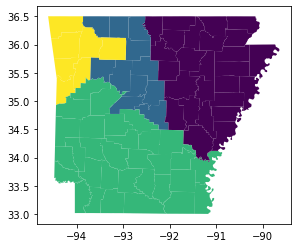

In [17]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : -1 for i in G.nodes }
for j in range(k):
    district = districts[j]
    for i in district:
        labeling[i] = j

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()